In [1]:
import numpy as np
from matplotlib import pyplot as plt
import json
from shapely.geometry import Polygon, MultiPolygon
import pandas as pd

%config InlineBackend.figure_format = 'retina'

In [2]:
class TopoJSON:
    def __init__(self, fn):
        self.amap = json.load(open(fn))
        
        scale = np.array( self.amap["transform"]["scale"] )
        translate = np.array( self.amap["transform"]["translate"] )
        
        arcs = [ np.array(arc).cumsum(axis=0) for arc in self.amap["arcs"] ]
        arcs = [arc*scale for arc in arcs]
        self.arcs = [arc-translate for arc in arcs]
        
    def get_counties_by_name(self, name):
        geoms = self.amap["objects"]["counties"]["geometries"]
        
        return [geom for geom in geoms if geom["properties"]["NAME"]==name]
    
    def get_county(self, i):
        return self.amap["objects"]["counties"]["geometries"][i]
    
    def get_counties(self):
        return self.amap["objects"]["counties"]["geometries"]
    
    def _get_points(self, arcs):
        assert type(arcs)==list
        
        arcpts = []
        for arc in arcs:
            arcpts.append( self.arcs[ ~arc ][::-1] if arc<0 else self.arcs[arc] )
        return np.vstack( arcpts )
    
    def _get_polygon( self, arcs ):
        rings = [self._get_points(x) for x in arcs]
        
        return Polygon( rings[0], rings[1:] )
    
    def _get_multipolygon( self, arcs ):
        polys = [self._get_polygon(x) for x in arcs]
        return MultiPolygon( polys )
    
    def _get_shape(self, geom):
        
        if geom["type"] == "Polygon":
            return self._get_polygon( geom["arcs"] )
        
        if geom["type"] == "MultiPolygon":
            return self._get_multipolygon( geom["arcs"] )
        
        if geom["type"] is None:
            return None
        
        print( geom )
        raise Exception("what")
        
    def get_centroid(self, i):
        county = self.get_county(i)
        

In [3]:
def open_friendbin(fn):
    c2c = open(fn, mode="rb").read()
    
    view = np.frombuffer( c2c, dtype=np.uint8 )
    
    num_counties = int((len(view) * 2)**0.5)
    assert num_counties == 3142
    
    # each uint8 packs two 4-bit numbers
    left = (view & 0b11110000) >> 4
    right = view & 0b1111
    
    c = np.empty((left.size + right.size,), dtype=left.dtype)
    c[0::2] = left
    c[1::2] = right
    
    return c.reshape( (num_counties, -1) )

Parse `county2county.binary` into a uint8 matrix. The i, jth cell is the relative likelihood that people in county i will have friends in county j. Each cell is a number between 1 and 8.

In [4]:
counties = open_friendbin("data/county2county.binary")

The New York Times map defines the "1" value as "100x as likely to be friends" and "8" as "1x as likely to be friends". Translate each integer value into its linear probability.

In [5]:
choices = 1/np.logspace(2,0,8)
friend_likelihood = choices[ counties-1 ]

Standardize by row, so that the total probability of friendships from one county to all other counties is exactly 1.

**Hacknology Alert** this seems fishy

In [6]:
friend_likelihood = (friend_likelihood.T / friend_likelihood.sum(axis=1)).T

Let's take a quick look-see at the matrix.

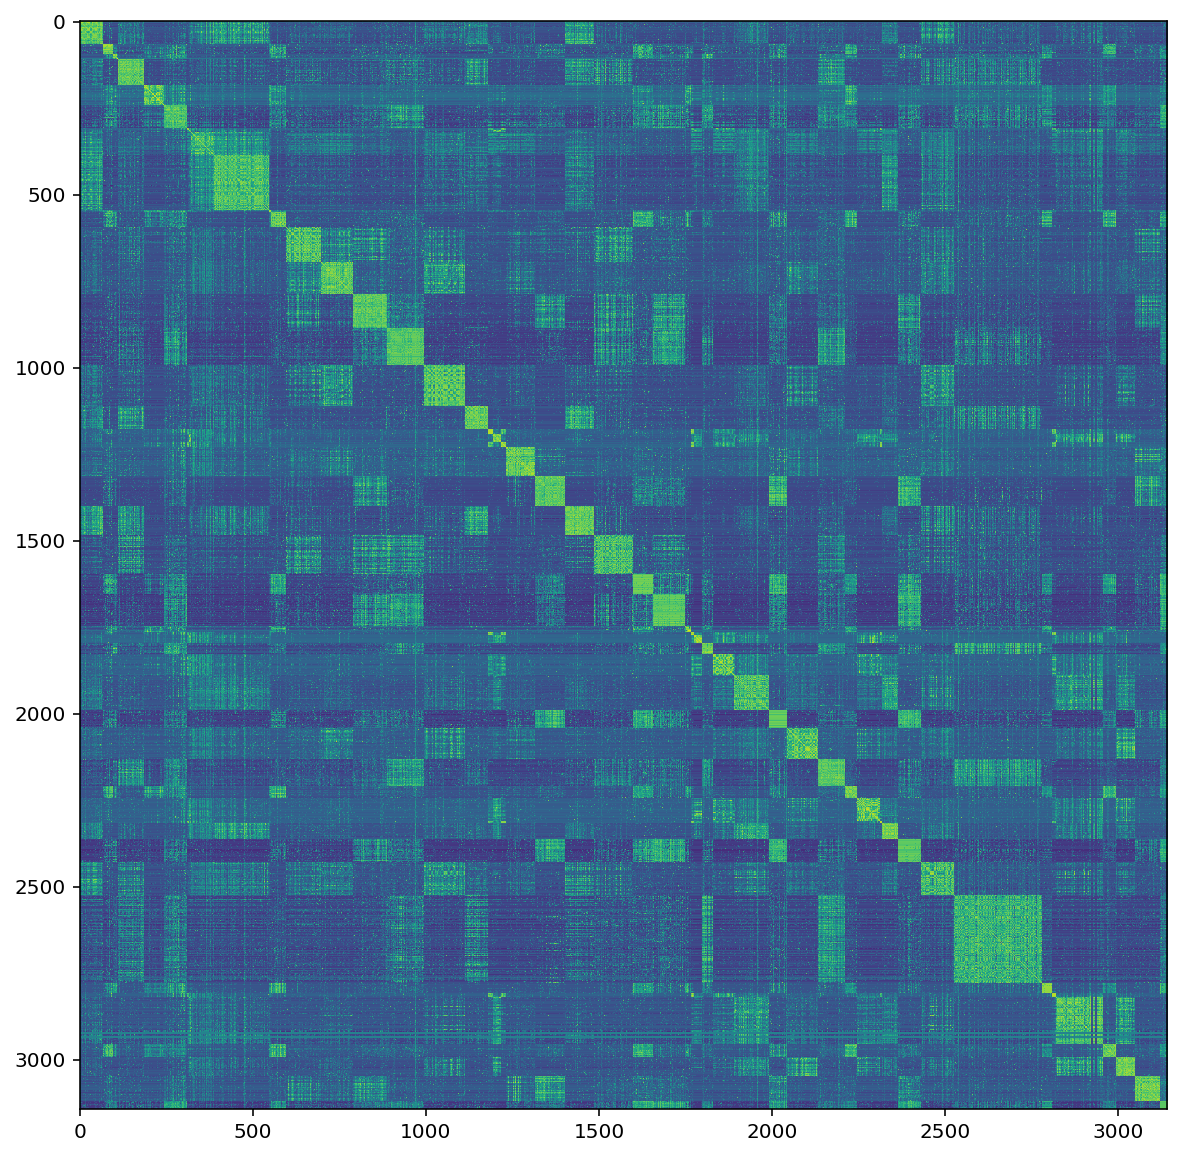

In [7]:
plt.figure(figsize=(10,10))
plt.imshow( np.log(friend_likelihood) )

Right away you can see some communities. The squares along the diagonals are states.

Next grab the county centroids. The NYT's visualization came with a map, and here I parse the map data and generate centroids.

In [8]:
tj = TopoJSON("data/final-map.json")

shapes = [ tj._get_shape( county ) for county in tj.get_counties() ]

centroids = np.array( [shape.centroid.coords[0] if shape is not None else [np.nan,np.nan] for shape in shapes] )

geoids = [county["properties"]["GEOID"] for county in tj.get_counties()]

county_centroids_df = pd.DataFrame({"county":geoids, "x":centroids[:,0], "y":centroids[:,1]})


In [9]:
county_centroids_df.head()

,county,x,y
0,01005,6.199450e+06,2.085725e+06
1,01023,5.929019e+06,2.076362e+06
2,01035,6.054290e+06,2.021422e+06
3,01051,6.120340e+06,2.158651e+06
4,01065,5.981100e+06,2.163975e+06


Merge with the NYT's own `county-info.csv`, which relates matrix indices with FIPS county codes.

In [10]:
countyinfo = pd.read_csv("data/county-info.csv", index_col="id", dtype={"id":int, "county":str})
countyinfo.head()

,county,sh_usfr_within_50miles,sh_usfr_within_100miles,sh_usfr_within_500miles
id,,,,
0,01001,0.57,0.69,0.87
1,01003,0.53,0.57,0.83
2,01005,0.59,0.71,0.90
3,01007,0.75,0.80,0.92
4,01009,0.75,0.80,0.92


In [11]:
countyinfo = countyinfo.merge( county_centroids_df, on="county")
countyinfo.head()

,county,sh_usfr_within_50miles,sh_usfr_within_100miles,sh_usfr_within_500miles,x,y
0,01001,0.57,0.69,0.87,6.075210e+06,2.147266e+06
1,01003,0.53,0.57,0.83,5.992234e+06,1.937472e+06
2,01005,0.59,0.71,0.90,6.199450e+06,2.085725e+06
3,01007,0.75,0.80,0.92,6.025337e+06,2.194381e+06
4,01009,0.75,0.80,0.92,6.066162e+06,2.308575e+06


Find the distance between all pairs of counties

In [12]:
from scipy.spatial.distance import pdist, squareform

In [13]:
dists = squareform( pdist( countyinfo[["x","y"]].values ) )

Now we have a nxn matrix of friendship probabilities, and a nxn matrix of county distances. We can take a look at a scatter plot of county distances against friendship probabilities:

In [45]:
idx = np.random.randint(0, 3142*3142-1, size=1000000)

[]

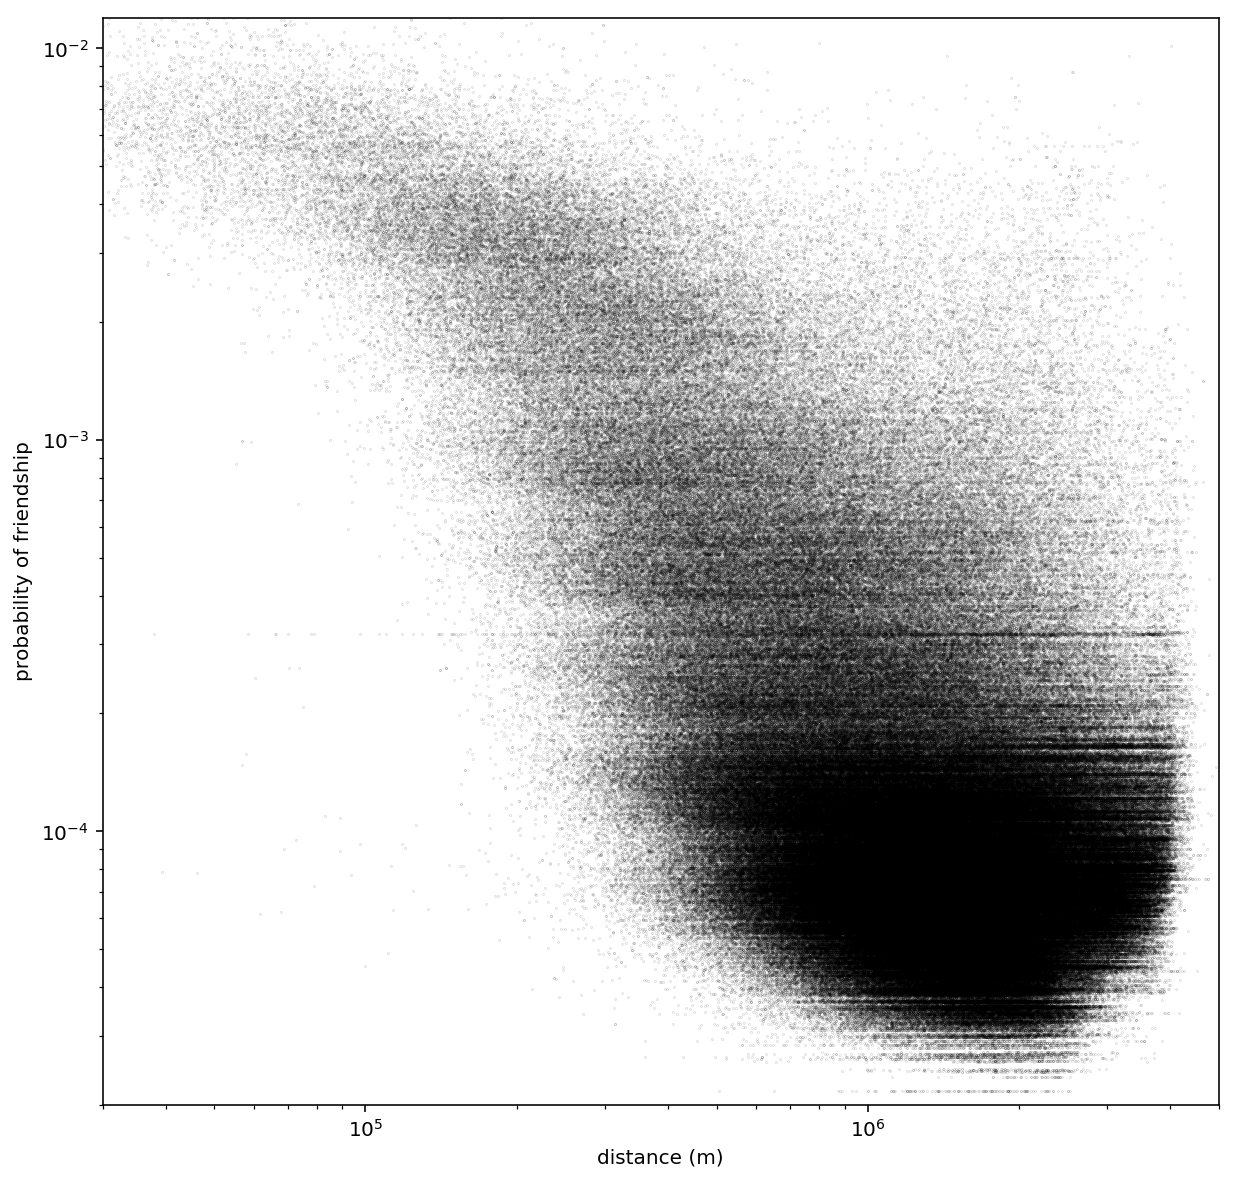

In [74]:
fig, ax = plt.subplots(figsize=(10,10))

#plt.figure(figsize=(10,10))
ax.scatter( dists.ravel()[idx]+1, # +1 to avoid breaking on dist==0
             friend_likelihood.ravel()[idx], 
             s=0.003, c="black" )
ax.set_xlim(3e4, 5e6)
ax.set_ylim(0.00002, 0.012)

ax.set_xlabel("distance (m)")
ax.set_ylabel("probability of friendship")

ax.loglog()



A roughly linear relationship between distance and probability implies a power law relationship.

$$ P(d) \propto d^{m} $$

In particular, this seems to be a piecewise power law, with two regimes. The kink is around 120 km (75 miles), with a lower power law exponent below and a higher above. This is about the distance at which a round-trip journey becomes multi-day.

A kinked power-law for human travel has also been observed by Eric Fischer [in OpenStreetMap GPS traces](https://www.flickr.com/photos/walkingsf/8166135552/in/photolist-drBzAy-bpkHy8-bjccY6-b4qHEn-aWjqa4-aSswz4-aEGGsd-axKzTa-auPLtN-auMUzj-atLsy9-aqGjdC-ahRV5V-ag2Yb7-afYLU4-bCUhPp-as8xno-akP4Tm-ahwcHw-agYDbQ). Interestingly, the elbow in Fischer's graph is also around 120 km. See also the work of [Nicola Scafetta](https://arxiv.org/abs/1206.5849).